In [1]:
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [2]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
STEP_SIZE = 5
EPOCHS = 20
TRANSFORMS = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

In [5]:
train_data = ImageFolder(root='./train', transform=TRANSFORMS)
val_data = ImageFolder(root='./test', transform=TRANSFORMS)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
CLASSES = train_data.classes
N_CLASSES = len(CLASSES)
print(CLASSES)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [7]:
class LeNet(Module):
    def __init__(self, input_channels, n_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 20, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, padding=2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(50 * 12 * 12, 500)
        self.fc2 = nn.Linear(500, n_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [8]:
model = LeNet(1, N_CLASSES).to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=0.1)

In [9]:
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

print('[INFO] Training started...\n')
for epoch in range(EPOCHS):
    model.train()

    total_train_loss = 0
    total_correct_train = 0
    total_val_loss = 0
    total_correct_val = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        total_correct_train += torch.sum(torch.argmax(pred, dim=1) == y).item()

    with torch.no_grad():
        model.eval()
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            total_val_loss += loss.item()
            total_correct_val += torch.sum(torch.argmax(pred, dim=1) == y).item()

    scheduler.step()

    avg_train_acc = total_correct_train / len(train_data)
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_acc = total_correct_val / len(val_data)
    avg_val_loss = total_val_loss / len(val_loader)

    print(f'[INFO] EPOCH: {epoch + 1}/{EPOCHS}')
    print(f'[INFO] Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
    print(f'[INFO] Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}\n')

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc'].append(avg_train_acc)
    history['val_acc'].append(avg_val_acc)

[INFO] Training started...

[INFO] EPOCH: 1/20
[INFO] Train Loss: 1.6258, Train Acc: 0.3595
[INFO] Val Loss: 1.4720, Val Acc: 0.4303

[INFO] EPOCH: 2/20
[INFO] Train Loss: 1.4055, Train Acc: 0.4572
[INFO] Val Loss: 1.3661, Val Acc: 0.4742

[INFO] EPOCH: 3/20
[INFO] Train Loss: 1.2738, Train Acc: 0.5114
[INFO] Val Loss: 1.2896, Val Acc: 0.5047

[INFO] EPOCH: 4/20
[INFO] Train Loss: 1.1508, Train Acc: 0.5642
[INFO] Val Loss: 1.2764, Val Acc: 0.5209

[INFO] EPOCH: 5/20
[INFO] Train Loss: 1.0118, Train Acc: 0.6238
[INFO] Val Loss: 1.2941, Val Acc: 0.5234

[INFO] EPOCH: 6/20
[INFO] Train Loss: 0.7661, Train Acc: 0.7293
[INFO] Val Loss: 1.3203, Val Acc: 0.5403

[INFO] EPOCH: 7/20
[INFO] Train Loss: 0.7106, Train Acc: 0.7494
[INFO] Val Loss: 1.3450, Val Acc: 0.5393

[INFO] EPOCH: 8/20
[INFO] Train Loss: 0.6722, Train Acc: 0.7625
[INFO] Val Loss: 1.3761, Val Acc: 0.5372

[INFO] EPOCH: 9/20
[INFO] Train Loss: 0.6387, Train Acc: 0.7771
[INFO] Val Loss: 1.4004, Val Acc: 0.5379

[INFO] EPOCH: 10/2

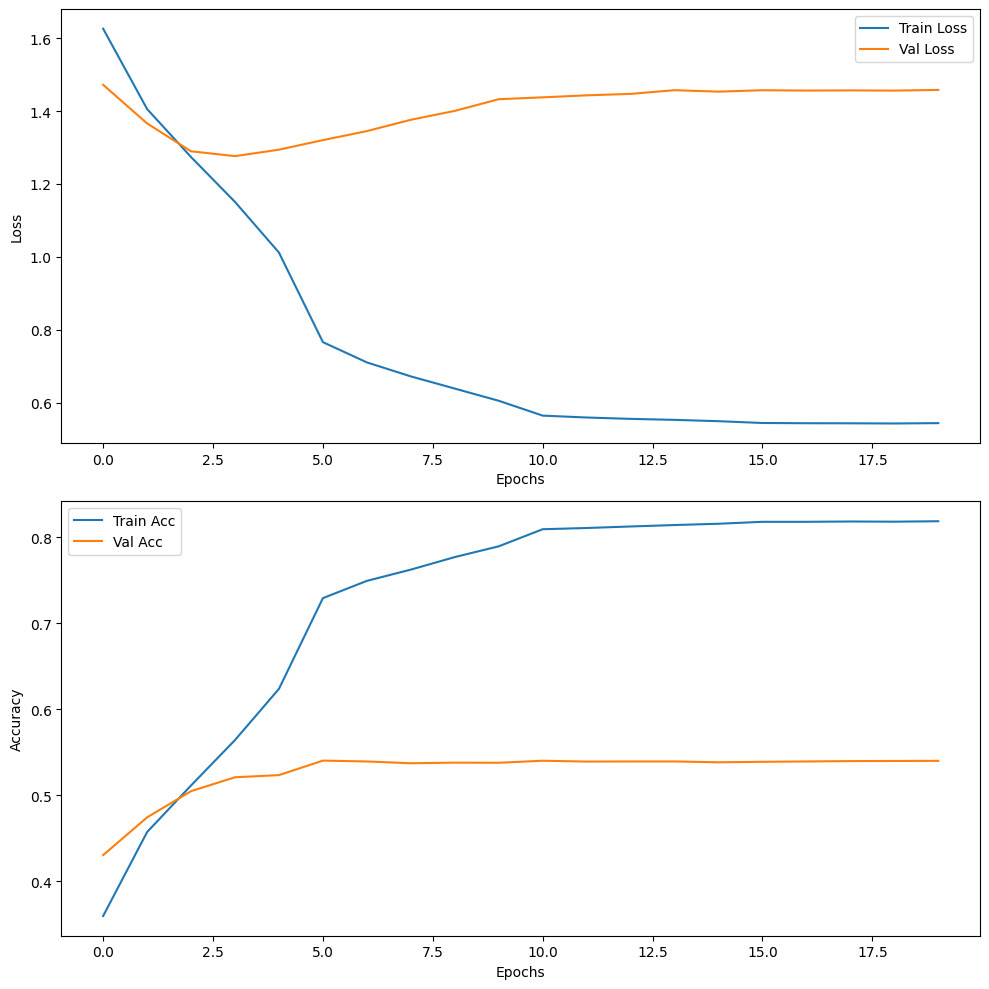

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history['train_acc'], label='Train Acc')
ax2.plot(history['val_acc'], label='Val Acc')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [11]:
torch.save(model.state_dict(), 'emotion_detection_model_lenet.pth')